In [198]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [279]:
# constants
VOLTAGE_ERR = 0.0005
CURRENT_ERR = 0.0001

RADIUS0 = 0.005
RADIUS1 = 2.5e-5
LENGTH = 0.4

In [11]:
# voltage - volt
# current - amp
lab_data = pd.read_csv('data.csv', index_col=['temp', 'mnt_num'])
lab_data.head()

mnt_series  voltage  current
temp mnt_num                              
23.5 1                 1   0.6532  0.03180
     2                 1   0.8455  0.04101
     3                 1   1.0270  0.04961
     4                 1   1.1603  0.05583
     5                 1   1.2850  0.06162

In [25]:
lab_data['power'] = lab_data.voltage * lab_data.current
lab_data['resistance'] = lab_data.voltage / lab_data.current
lab_data.drop(columns=['mnt_series'], inplace=True)

In [124]:
def gen_table(df, temp):
  df['current'] = df['current'] * 1000
  df['power'] = df['power'] * 1000
  df = df.round({
    'voltage': 3,
    'current': 1,
    'power': 1,
    'resistance': 3
  })
  fst_col = r'$\mathbf{{T = ' + str(temp) + r'}}\;\textbf{{\textcelsius}}$'
  df = df.astype('str')
  return df.to_latex(
    index=False,
    column_format='ccccc',
    header=[str(fst_col), r'$U$, В', r'$I$, мА', r'$Q$, мВт', r'$R$, Ом']
  )

In [125]:
for i, (name, group) in enumerate(lab_data.groupby(level=0)):
  with open(f'{OUTPUT_DIR}/table_temp{i}.tex', 'w') as f:
    f.write(gen_table(group.reset_index(level=1)[['voltage', 'current', 'power', 'resistance']], temp=name))

In [132]:
lab_data['voltage_lb'] = lab_data['voltage'] - VOLTAGE_ERR
lab_data['voltage_hb'] = lab_data['voltage'] + VOLTAGE_ERR
lab_data['current_lb'] = lab_data['current'] - CURRENT_ERR
lab_data['current_hb'] = lab_data['current'] + CURRENT_ERR

lab_data['power_lb'] = lab_data.voltage_lb * lab_data.current_lb
lab_data['power_hb'] = lab_data.voltage_hb * lab_data.current_hb
lab_data['resistance_lb'] = lab_data.voltage_lb / lab_data.current_hb
lab_data['resistance_hb'] = lab_data.voltage_hb / lab_data.current_lb

In [309]:
(lab_data.power_hb - lab_data.power_lb).groupby(level=0).mean() / 2

temp
23.5    0.000157
33.5    0.000157
43.5    0.000156
53.5    0.000165
63.5    0.000165
dtype: float64

In [310]:
(lab_data.resistance_hb - lab_data.resistance_lb).groupby(level=0).mean() / 2

temp
23.5    0.046108
33.5    0.048600
43.5    0.051608
53.5    0.051688
63.5    0.054387
dtype: float64

In [172]:
def plot_power_resistance(df, temp):
  y = df.resistance
  x = df.power
  yerr = np.vstack((y - df.resistance_lb, df.resistance_hb - y))
  xerr = np.vstack((x - df.power_lb, df.power_hb - x))

  lm = LinearRegression()
  lm.fit(np.array(x).reshape(-1, 1), y)

  x_pred = np.linspace(0, x.max(), 100).reshape(-1, 1)
  y_pred = lm.predict(x_pred)

  plt.plot(x_pred * 1000, y_pred)
  plt.errorbar(x * 1000, y, yerr=yerr, xerr=xerr * 1000, ls='None', ecolor='red')
  plt.scatter(x * 1000, y, s=5, c='black', zorder=10)
  plt.xlabel('$Q$, мВт')
  plt.ylabel('$R$, Ом')
  plt.title(f"$T = {temp}$ \\textcelsius")
  return lm

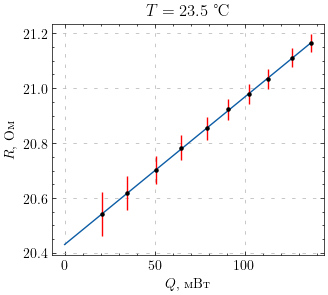

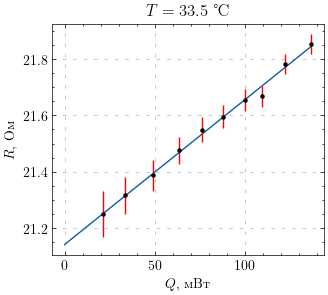

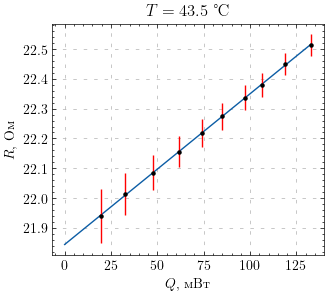

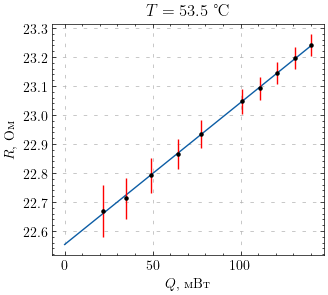

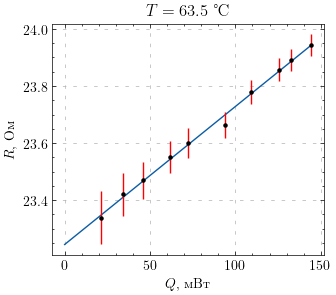

In [233]:
for i, (name, group) in enumerate(lab_data.groupby(level=0)):
  plt.figure(figsize=(3.5, 3))
  plot_power_resistance(group, name)
  plt.savefig(f'{OUTPUT_DIR}/pow_res_temp{i}.pgf')

In [178]:
lab_data_clr = lab_data.copy()
lab_data_clr.drop([(63.5, 6), (33.5, 8)], inplace=True)

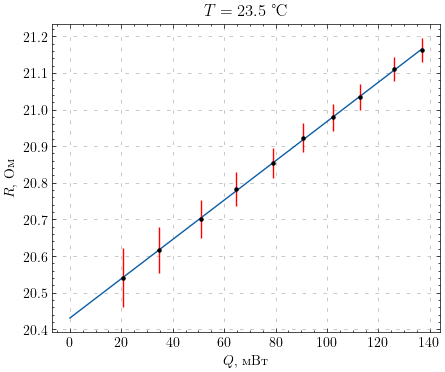

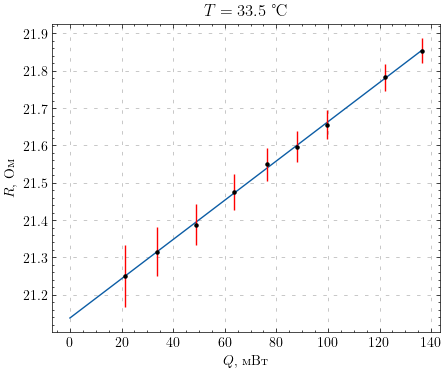

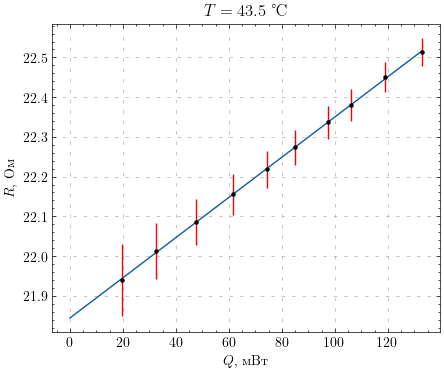

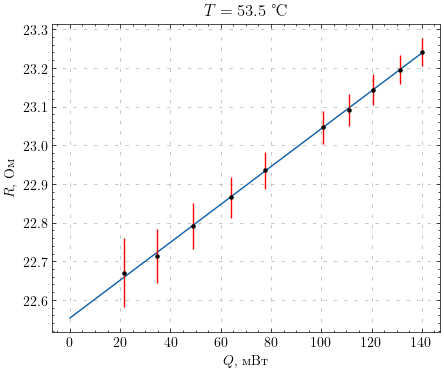

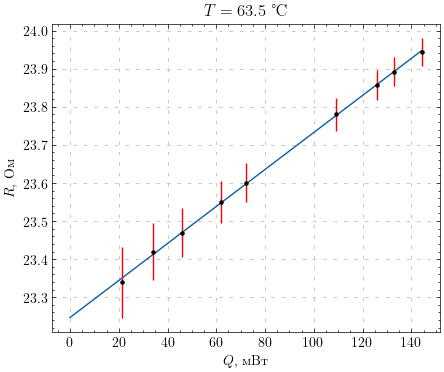

In [179]:
for i, (name, group) in enumerate(lab_data_clr.groupby(level=0)):
  plt.figure(figsize=(5, 4))
  plot_power_resistance(group, name)

In [290]:
def get_random_sample(df, column, err=None):
  if err is not None:
    return np.random.normal(df[column], err / 3)
  return np.random.normal(df[column], (df[column+'_hb'] - df[column+'_lb']) / 6)

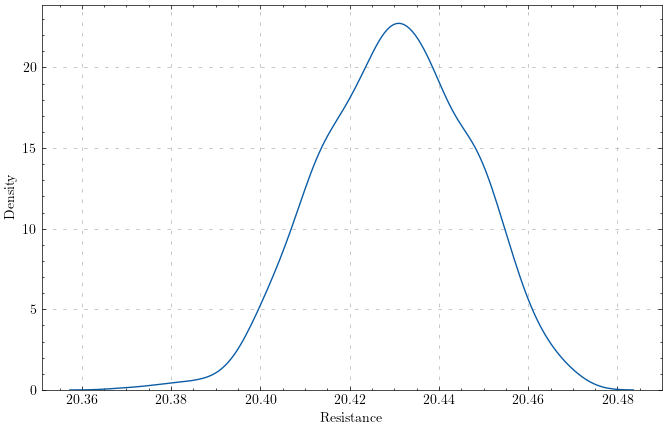

In [302]:
def generate_free_coefs(df, num=1000):
  np.random.seed(0)
  slopes = []
  coefs = []
  for i in range(num):
    y = get_random_sample(df, 'resistance')
    x = get_random_sample(df, 'power')

    lm = LinearRegression()
    lm.fit(np.array(x).reshape(-1, 1), y)
    coefs.append(lm.intercept_)
    slopes.append(1 / lm.coef_[0])

  return np.array(coefs), np.array(slopes)


plt.figure(figsize=(8, 5))
sns.kdeplot(generate_free_coefs(lab_data_clr.loc[23.5])[0])
plt.xlabel('Resistance');

In [292]:
res_0 = []
res_0_err = []
dPow_dRes = []
dPow_dRes_err = []
temps = []
for i, (name, group) in enumerate(lab_data.groupby(level=0)):
  coefs = generate_free_coefs(group)
  res_0.append(coefs[0].mean())
  res_0_err.append(coefs[0].std() * 2)
  dPow_dRes.append(coefs[1].mean())
  dPow_dRes_err.append(coefs[1].std() * 2)
  temps.append(name)

res_temp_data = pd.DataFrame({
  'resistance': res_0,
  'resistance_err': res_0_err,
  'dPow_dRes': dPow_dRes,
  'dPow_dRes_err': dPow_dRes_err,
  'temp': temps
}).set_index('temp')

res_temp_data

,resistance,resistance_err,dPow_dRes,dPow_dRes_err
temp,,,,
23.5,20.430295,0.033296,0.186399,0.011349
33.5,21.140865,0.034361,0.193939,0.012960
43.5,21.843623,0.036731,0.197740,0.014798
53.5,22.552998,0.036234,0.204423,0.014149
63.5,23.244047,0.035860,0.206691,0.014153


In [293]:
res_temp_data.resistance_err / res_temp_data.resistance

temp
23.5    0.001630
33.5    0.001625
43.5    0.001682
53.5    0.001607
63.5    0.001543
dtype: float64

In [311]:
def gen_res_temp_table(df):
  df = df.copy()
  df = df.round(3)
  df = df.astype('str')
  new = "$" + df['resistance'] + "\pm" + df['resistance_err'] + "$"
  new = new.to_frame()
  new['1'] = "$" + df['dPow_dRes'] + "\pm" + df['dPow_dRes_err'] + "$"
  new = new.T
  new.index = ["$\\mathbf{R_0}$, \\textbf{Ом}", "$\\mathbf{dQ/dR}$, \\textbf{Ом/К}"]
  new.columns = new.columns.map(str)
  new.columns.name = "$\\mathbf{T}$, \\textbf\\textcelsius"


  return new.to_latex(index_names=False,
                      buf=f'{OUTPUT_DIR}/table_res_temp.tex',
                      column_format='cccccc')

gen_res_temp_table(res_temp_data)

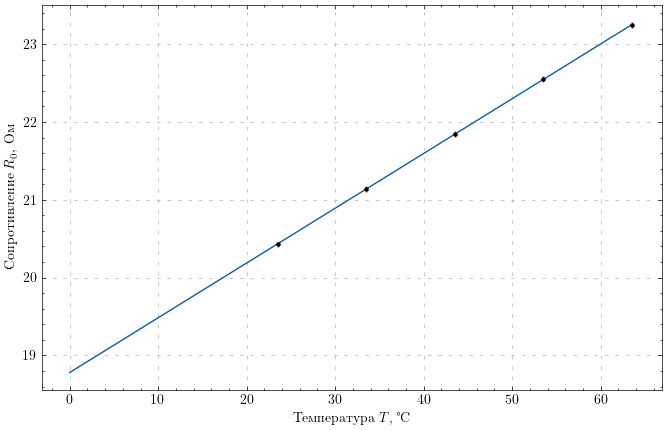

In [334]:
def plot_temp_res(df):
  x = df.temp
  y = df.resistance
  yerr = df.resistance_err

  lm = LinearRegression()
  lm.fit(np.array(x).reshape(-1, 1), y)

  x_pred = np.linspace(0, x.max(), 100).reshape(-1, 1)
  y_pred = lm.predict(x_pred)

  plt.plot(x_pred, y_pred)
  plt.errorbar(x, y, yerr=yerr, xerr=0.2, ls='None', ecolor='red')
  plt.scatter(x, y, s=5, c='black', zorder=10)
  plt.xlabel("Температура $T$, \\textcelsius")
  plt.ylabel("Сопротивление $R_0$, Ом")

plt.figure(figsize=(8, 5))
plot_temp_res(res_temp_data.reset_index())
plt.savefig(f"{OUTPUT_DIR}/temp_res.pgf")

dR/dT (0.07042432703874216, 0.0007825524143698109)
R(T=0) (18.778884447746968, 0.03535346161656296)


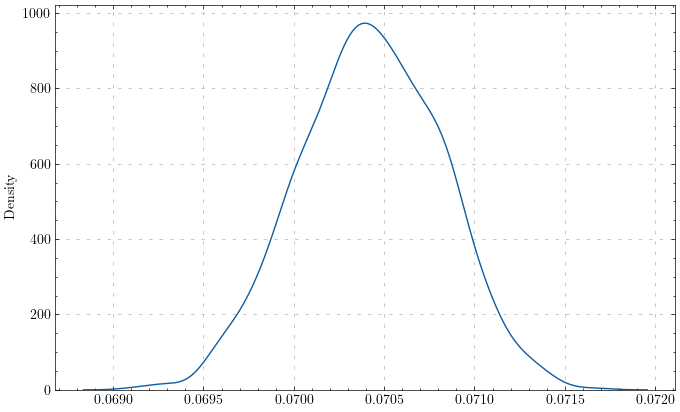

In [336]:
def generate_slopes(df, num=1000):
  np.random.seed(0)
  slopes = []
  intercepts = []
  for i in range(num):
    x = get_random_sample(df, 'temp', 0.2)
    y = get_random_sample(df, 'resistance', df.resistance_err)

    lm = LinearRegression()
    lm.fit(np.array(x).reshape(-1, 1), y)
    slopes.append(lm.coef_[0])
    intercepts.append(lm.intercept_)

  return np.array(slopes), np.array(intercepts)

coefs, intercepts = generate_slopes(res_temp_data.reset_index())
plt.figure(figsize=(8, 5))
sns.kdeplot(coefs)
dRes_dT = coefs.mean()
dRes_dT_err = coefs.std() * 2
R_T_0 = intercepts.mean()
R_T_0_err = intercepts.std() * 2
print("dR/dT", (coefs.mean(), coefs.std() * 2))
print("R(T=0)", (intercepts.mean(), intercepts.std() * 2))

In [340]:
alpha_hb = (dRes_dT + dRes_dT_err) / (R_T_0 - R_T_0_err)
alpha_lb = (dRes_dT - dRes_dT_err) / (R_T_0 + R_T_0_err)
alpha = (alpha_lb + alpha_hb) / 2
((alpha_lb + alpha_hb) / 2, (alpha_hb - alpha_lb) / 2)

(0.003750278675460932, 4.873227427968567e-05)

In [343]:
(0.0039 - alpha) / 0.0039

0.03839008321514557

In [347]:
def chi(dQ_dR, dR_dT):
  return dQ_dR * dR_dT / (2 * 3.1415 * LENGTH) * np.log(RADIUS0 / RADIUS1)

def get_true_chi(temps):
  core_temp = [20, 30, 40, 50, 60, 70]
  chis = [0.0259, 0.0267, 0.0276, 0.0283, 0.029, 0.0296]
  return np.interp(temps, core_temp, chis)

chi_data = pd.DataFrame(index=res_temp_data.index)
chi_data['chi'] = chi(res_temp_data.dPow_dRes, dRes_dT)
chi_data['chi_hb'] = chi(res_temp_data.dPow_dRes + res_temp_data.dPow_dRes_err, dRes_dT + dRes_dT_err)
chi_data['chi_lb'] = chi(res_temp_data.dPow_dRes - res_temp_data.dPow_dRes_err, dRes_dT - dRes_dT_err)

chi_data['ln_chi'] = np.log(chi_data.chi)
chi_data['ln_chi_hb'] = np.log(chi_data.chi_hb)
chi_data['ln_chi_lb'] = np.log(chi_data.chi_lb)
chi_data['ln_temp'] = np.log(chi_data.index + 273.15)

chi_data['chi_true'] = get_true_chi(chi_data.index)
chi_data

,chi,chi_hb,chi_lb,ln_chi,ln_chi_hb,ln_chi_lb,ln_temp,chi_true
temp,,,,,,,,
23.5,0.027674,0.029686,0.025701,-3.587251,-3.517095,-3.661244,5.692553,0.026180
33.5,0.028794,0.031059,0.026571,-3.547598,-3.471862,-3.627933,5.725707,0.027015
43.5,0.029358,0.031906,0.026859,-3.528188,-3.444971,-3.617144,5.757797,0.027845
53.5,0.030350,0.032812,0.027936,-3.494946,-3.416971,-3.577846,5.788889,0.028545
63.5,0.030687,0.033153,0.028268,-3.483915,-3.406632,-3.566022,5.819044,0.029210


In [307]:
chi_data.chi_hb - chi_data.chi_lb

temp
23.5    0.003985
33.5    0.004488
43.5    0.005046
53.5    0.004876
63.5    0.004885
dtype: float64

In [371]:
def gen_chi_table(df):
  df = df.copy()
  df['chi_err'] = (df['chi_hb'] - df['chi_lb']) / 2
  df['ln_chi_err'] = (df['ln_chi_hb'] - df['ln_chi_lb']) / 2
  df = df.round(4)
  df = df.astype('str')

  new = "$" + df['chi'] + "\pm" + df['chi_err'] + "$"
  new = new.to_frame()
  # new = df['chi']
  new['1'] = df.chi_true
  new['2'] = "$" + df['ln_chi'] + "\pm" + df['ln_chi_err'] + "$"
  new['3'] = df['ln_temp']
  new = new.T
  new.index = ["$\\mathbf{\\varkappa}$", "$\\varkappa_{ист}$", "$\\mathbf{\\ln\\varkappa}$", "$\\mathbf{\\ln T}$"]
  new.columns = new.columns.map(str)
  new.columns.name = "$\\mathbf{T}$, \\textbf\\textcelsius"


  return new.to_latex(index_names=False,
                      buf=f'{OUTPUT_DIR}/table_chi.tex',
                      column_format='cccccc')

gen_chi_table(chi_data)

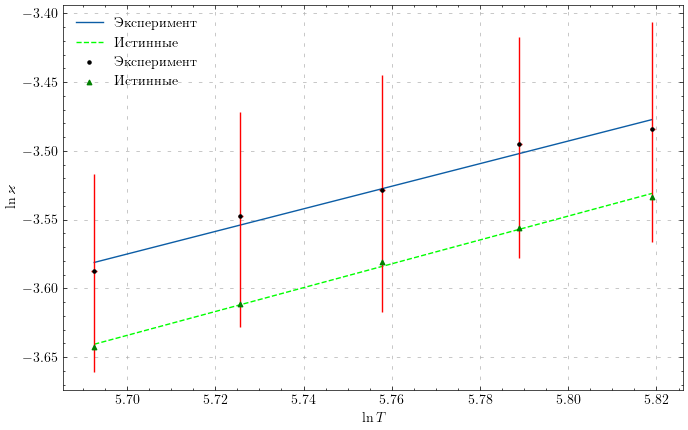

In [373]:
def plot_ln_temp_chi(df):
  y = np.log(df.chi)
  y_true = np.log(df.chi_true)
  x = np.log(df.temp + 273.15)

  yerr = np.vstack((y - np.log(df.chi_lb), np.log(df.chi_hb) - y))
  xerr = np.log(df.temp + 0.2 + 273.15) - x

  lm = LinearRegression()
  lm.fit(np.array(x).reshape(-1, 1), y)
  lm_true = LinearRegression().fit(np.array(x).reshape(-1, 1), y_true)

  x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
  y_pred = lm.predict(x_pred)
  y_pred_true = lm_true.predict(x_pred)

  plt.plot(x_pred, y_pred, label='Эксперимент')
  plt.plot(x_pred, y_pred_true, c='lime', linestyle='--', label='Истинные')
  plt.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor='red')
  plt.scatter(x, y, s=5, c='black', zorder=10, label='Эксперимент')
  plt.scatter(x, y_true, s=10, c='green', zorder=10, label='Истинные', marker="^")
  plt.xlabel("$\\ln T$")
  plt.ylabel("$\\ln \\varkappa$")
  plt.legend(loc='upper left')

plt.figure(figsize=(8, 5))
plot_ln_temp_chi(chi_data.reset_index())
plt.savefig(f'{OUTPUT_DIR}/ln_chi.pgf')

In [368]:
beta_true = np.polyfit(np.log(chi_data.index + 273.15), np.log(chi_data.chi_true), 1)[0]
beta_true

0.8678231385520334

In [329]:
chi_data

,chi,chi_hb,chi_lb,ln_chi,ln_chi_hb,ln_chi_lb,ln_temp
temp,,,,,,,
23.5,0.027674,0.029686,0.025701,-3.587251,-3.517095,-3.661244,5.692553
33.5,0.028794,0.031059,0.026571,-3.547598,-3.471862,-3.627933,5.725707
43.5,0.029358,0.031906,0.026859,-3.528188,-3.444971,-3.617144,5.757797
53.5,0.030350,0.032812,0.027936,-3.494946,-3.416971,-3.577846,5.788889
63.5,0.030687,0.033153,0.028268,-3.483915,-3.406632,-3.566022,5.819044


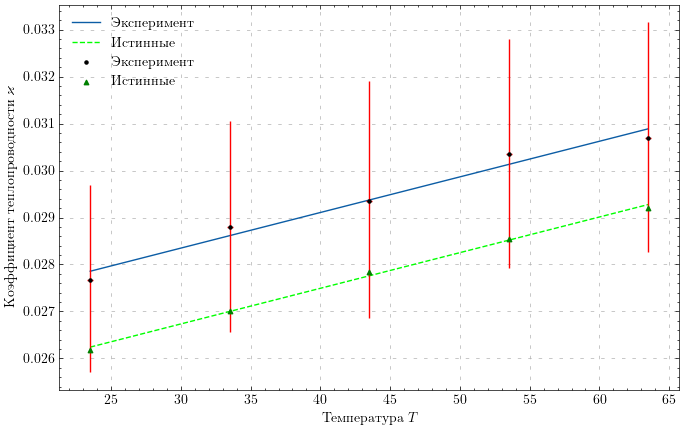

In [375]:
def plot_temp_chi(df):
  y = df.chi
  x = df.temp + 273.15
  y_true = df.chi_true

  yerr = np.vstack((y - df.chi_lb, df.chi_hb - y))

  chi_model = np.poly1d(np.polyfit(x, y, 1.81))
  chi_model_true = np.poly1d(np.polyfit(x, y_true, 1.868))

  x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
  y_pred = chi_model(x_pred)
  y_pred_true = chi_model_true(x_pred)


  plt.plot(x_pred - 273.15, y_pred, label='Эксперимент')
  plt.plot(x_pred - 273.15, y_pred_true, c='lime', linestyle='--', label='Истинные')
  plt.errorbar(x - 273.15, y, yerr=yerr, xerr=0.2, ls='None', ecolor='red')
  plt.scatter(x - 273.15, y, s=5, c='black', zorder=10, label='Эксперимент')
  plt.scatter(x - 273.15, y_true, s=10, c='green', zorder=10, label='Истинные', marker="^")
  plt.xlabel("Температура $T$")
  plt.ylabel("Коэффициент теплопроводности $\\varkappa$")
  plt.legend(loc='upper left')

plt.figure(figsize=(8, 5))
plot_temp_chi(chi_data.reset_index())
plt.savefig(f'{OUTPUT_DIR}/chi.pgf')

(0.813023868433859, 0.5165674932862505)

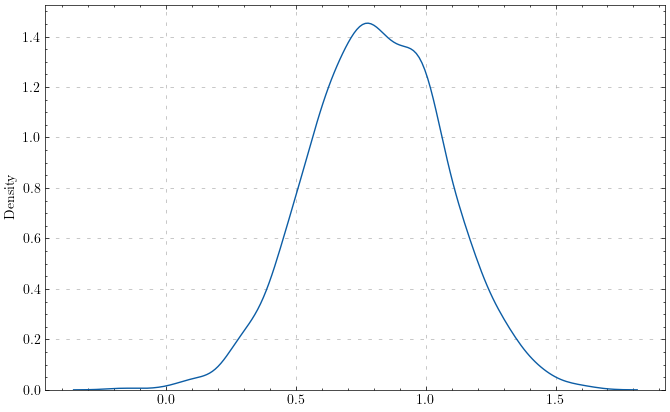

In [324]:
def generate_betas(df, num=1000):
  np.random.seed(0)
  slopes = []
  for i in range(num):
    y = get_random_sample(df, 'ln_chi')
    x = get_random_sample(df, 'ln_temp', 0)

    lm = LinearRegression()
    lm.fit(np.array(x).reshape(-1, 1), y)
    slopes.append(lm.coef_[0])

  return np.array(slopes)

plt.figure(figsize=(8, 5))
betas = generate_betas(chi_data)
sns.kdeplot(betas);
(betas.mean(), betas.std() * 2)

In [376]:
betas.std() * 2 / betas.mean()

0.635365717222205

In [377]:
beta_true / 0.5

1.7356462771040668